<a href="https://colab.research.google.com/github/juancruzalbornoz/ProyectoDS/blob/main/ProyectoDSParteIAlbornozJuanCruz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto Data Science - Parte I - Juan Cruz Albornoz**

## **Abstract**

Este conjunto de datos sintético ha sido generado para simular un escenario real de producción vinícola, abarcando 2100 lotes de producción hipotéticos. Contiene 20 variables que describen diversos aspectos del proceso, desde la materia prima hasta el producto final y su comercialización. Se incluyen identificadores únicos, fechas clave como cosecha y producción, y características categóricas como la bodega, región de origen, tipo de uva utilizada, condiciones climáticas durante la cosecha y el tipo de barrica empleado para la crianza. Además, se registran parámetros cuantitativos del proceso: cantidad de uva procesada, temperaturas promedio en cosecha y fermentación, y los tiempos dedicados a la fermentación y crianza en meses. Las propiedades físico-químicas del vino final, como el nivel de acidez (pH) y el contenido alcohólico, también están presentes. Crucialmente, el dataset incorpora métricas de evaluación y rendimiento: un puntaje de calidad numérico (70-100), el número total de botellas producidas, el costo unitario de producción y el precio de mercado por botella. Para facilitar tareas de clasificación y análisis de segmentación, se ha añadido una variable categórica derivada, 'Categoria_Calidad' (Standard, Premium, Super Premium), basada en el puntaje numérico. Con el objetivo de reflejar desafíos del mundo real, algunas columnas como la temperatura de cosecha, el tipo de barrica, el nivel de acidez y el precio de mercado contienen valores nulos introducidos aleatoriamente (~8% de probabilidad). Este dataset es una herramienta versátil diseñada para la práctica en ciencia de datos, permitiendo realizar análisis exploratorios, tareas de limpieza y preprocesamiento (imputación de nulos, codificación de variables categóricas, escalado), ingeniería de características (especialmente con fechas) y, fundamentalmente, el desarrollo y evaluación de modelos predictivos tanto de regresión (ej. predecir precio o puntaje) como de clasificación (predecir la categoría de calidad). El análisis se centrará en identificar los factores que más influyen en la categoría de calidad final del vino.

## **Configuración**

### Configuración del Entorno

In [6]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Librería especializada en visualización de datos ausentes
import missingno as msno

# Librerías de Scikit-learn para imputación
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split # Para demostrar buenas prácticas

# Configuraciones adicionales (opcional)
pd.set_option('display.max_columns', None) # Mostrar todas las columnas
sns.set_style('whitegrid') # Estilo de gráficos Seaborn
plt.rcParams['figure.figsize'] = (10, 6) # Tamaño de figuras Matplotlib

### Configuración de Dataset

In [7]:
# --- Parámetros de Configuración ---
num_rows = 2100
start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 12, 31)
null_probability = 0.08 # Probabilidad de que un valor sea nulo en columnas seleccionadas

# --- Listas de Valores Categóricos ---
wineries = [f'Bodega_{chr(65+i)}' for i in range(10)] # Bodega_A, Bodega_B, ...
regions = ['Mendoza', 'San Juan', 'Salta', 'La Rioja', 'Patagonia']
grape_types = ['Malbec', 'Cabernet Sauvignon', 'Bonarda', 'Syrah', 'Merlot', 'Chardonnay', 'Torrontés']
weather_conditions = ['Soleado', 'Nublado', 'Lluvioso', 'Variable']
barrel_types = ['Roble Francés', 'Roble Americano', 'Acero Inoxidable', 'Sin Crianza']

# --- Generación de Datos ---
data = {}

# IDs únicos
data['ID_Lote'] = range(1, num_rows + 1)

# Fechas
production_dates = [start_date + timedelta(days=random.randint(0, (end_date - start_date).days)) for _ in range(num_rows)]
data['Fecha_Produccion'] = production_dates
# La cosecha debe ser anterior a la producción
data['Fecha_Cosecha'] = [d - timedelta(days=random.randint(30, 180)) for d in production_dates]

# Datos Categóricos
data['Bodega'] = random.choices(wineries, k=num_rows)
data['Region'] = random.choices(regions, k=num_rows)
data['Tipo_Uva'] = random.choices(grape_types, k=num_rows)
data['Clima_Cosecha'] = random.choices(weather_conditions, k=num_rows)

# Datos Numéricos (con algo de lógica y aleatoriedad)
data['Cantidad_Uva_Kg'] = np.random.uniform(1000, 15000, num_rows).round(2)
data['Temp_Prom_Cosecha_C'] = np.random.uniform(15, 30, num_rows).round(1)
data['Tiempo_Fermentacion_Dias'] = np.random.randint(7, 25, num_rows)
data['Temp_Fermentacion_C'] = np.random.uniform(18, 32, num_rows).round(1)

# Crianza y tipo de barril (con cierta correlación)
aging_times = []
barrel_selection = []
for _ in range(num_rows):
    barrel = random.choice(barrel_types)
    barrel_selection.append(barrel)
    if barrel in ['Acero Inoxidable', 'Sin Crianza']:
        aging_times.append(0) # Sin crianza en madera
    else:
        aging_times.append(random.randint(3, 24)) # Meses de crianza
data['Tiempo_Crianza_Meses'] = aging_times
data['Tipo_Barrica'] = barrel_selection

data['Nivel_Acidez_pH'] = np.random.uniform(3.0, 4.2, num_rows).round(2)
data['Contenido_Alcohol_Pct'] = np.random.uniform(11.5, 15.5, num_rows).round(1)

# Calidad (influenciada ligeramente por otros factores para realismo)
base_quality = np.random.randint(75, 95, num_rows)
quality_adjustment = (np.array(data['Tiempo_Crianza_Meses']) / 6) - abs(np.array(data['Temp_Fermentacion_C']) - 25) / 5 # Ajuste simple
data['Puntaje_Calidad'] = np.clip(base_quality + quality_adjustment, 70, 100).round(0).astype(int) # Puntaje 70-100

# Producción y Costos/Precios
# Aprox. 0.6 a 0.8 litros por kg -> 0.8 a 1.1 botellas de 750ml por kg
yield_factor = np.random.uniform(0.8, 1.1, num_rows)
data['Botellas_Producidas'] = (data['Cantidad_Uva_Kg'] * yield_factor).round(0).astype(int)

base_cost = np.random.uniform(1.5, 5.0, num_rows)
cost_adjustment = (np.array(data['Tiempo_Crianza_Meses']) * 0.15) + (np.array(data['Cantidad_Uva_Kg']) / 5000) # Más crianza/volumen = más costo
data['Costo_Produccion_x_Botella'] = (base_cost + cost_adjustment).round(2)

base_price_factor = np.random.uniform(1.8, 3.5, num_rows)
price_adjustment = (np.array(data['Puntaje_Calidad']) - 80) * 0.1 + (np.array(data['Tiempo_Crianza_Meses']) * 0.05)
precio_calculado = (np.array(data['Costo_Produccion_x_Botella']) * base_price_factor + price_adjustment).round(2)
precio_minimo = np.array(data['Costo_Produccion_x_Botella']) * 1.1
data['Precio_Mercado_x_Botella'] = np.maximum(precio_calculado, precio_minimo) # Precio siempre >= 110% del costo

# --- Crear DataFrame ---
df = pd.DataFrame(data)

# --- Introducir Valores Nulos (NaN) ---
cols_with_nulls = [
    'Temp_Prom_Cosecha_C',
    'Nivel_Acidez_pH',
    'Tipo_Barrica', # Puede ser nulo si no se registró
    'Precio_Mercado_x_Botella' # Puede ser nulo si aún no se vende
]

for col in cols_with_nulls:
    # Asegurarse de que la columna puede manejar NaN (convertir a float si es int)
    if pd.api.types.is_integer_dtype(df[col]):
        # Verificar si np.nan es compatible con el tipo de datos de la columna
        if not pd.api.types.is_float_dtype(df[col]):
            df[col] = df[col].astype(float) # Convertir a float para permitir NaN

    mask = np.random.choice([True, False], size=num_rows, p=[null_probability, 1 - null_probability])
    if pd.api.types.is_object_dtype(df[col]): # Para columnas de texto/object
        df.loc[mask, col] = None
    else: # Para columnas numéricas
        df.loc[mask, col] = np.nan


# --- Añadir Columna Derivada para Clasificación ---
# Definir los límites (bins) y las etiquetas para las categorías de calidad
bins = [69, 84, 92, 101] # Límites: (69-84], (84-92], (92-101]
labels = ['Standard', 'Premium', 'Super Premium']

# Crear la nueva columna 'Categoria_Calidad'
df['Categoria_Calidad'] = pd.cut(df['Puntaje_Calidad'], bins=bins, labels=labels, right=True)

# --- Mostrar Información y Salida (Opcional) ---
# print("--- Primeras 5 filas del DataFrame ---")
# print(df.head().to_markdown(index=False))
# print("\n--- Información del DataFrame (Tipos de datos y Nulos) ---")
# df.info()
# print("\n--- Distribución de Categoria_Calidad ---")
# print(df['Categoria_Calidad'].value_counts())

# --- Generar Salida CSV (Opcional) ---
# df.to_csv('produccion_vino_datos_clasificacion.csv', index=False, encoding='utf-8')
# print("\nArchivo 'produccion_vino_datos_clasificacion.csv' generado exitosamente.")

## **Dataset**

### Descripción de Columnas

**ID_Lote**: *(Numérico - Entero)* Identificador único para cada lote de producción de vino.

**Fecha_Produccion**: *(Fecha)* Fecha en que se realizó o finalizó el proceso principal de producción del lote.

**Fecha_Cosecha**: *(Fecha)* Fecha en que se cosecharon las uvas utilizadas para ese lote.

**Bodega**: *(Categórico)* Nombre ficticio de la bodega productora.

**Region**: *(Categórico)* Región geográfica (ficticia o real) donde se ubica la bodega o se cultivaron las uvas.

**Tipo_Uva**: *(Categórico)* Variedad principal de uva utilizada en el vino (ej. Malbec, Chardonnay).

**Clima_Cosecha**: *(Categórico)* Condición climática general durante el período de cosecha (ej. Soleado, Lluvioso).

**Cantidad_Uva_Kg**: *(Numérico - Decimal)* Peso total en kilogramos de uvas procesadas para el lote.

**Temp_Prom_Cosecha_C**: *(Numérico - Decimal)* Temperatura promedio (°C) registrada durante la cosecha. (Puede tener nulos).

**Tiempo_Fermentacion_Dias**: *(Numérico - Entero)* Duración del proceso de fermentación en días.

**Temp_Fermentacion_C**: *(Numérico - Decimal)* Temperatura controlada o promedio (°C) durante la fermentación.

**Tiempo_Crianza_Meses**: *(Numérico - Entero)* Número de meses que el vino pasó en crianza (usualmente en barricas, 0 si no tuvo).

**Tipo_Barrica**: *(Categórico)* Material o tipo de recipiente usado para la crianza (ej. Roble Francés, Acero Inoxidable). (Puede tener nulos).

**Nivel_Acidez_pH**: *(Numérico - Decimal)* Medida del pH del vino, indicativo de su acidez total. (Puede tener nulos).

**Contenido_Alcohol_Pct**: *(Numérico - Decimal)* Porcentaje de alcohol por volumen en el vino final.

**Puntaje_Calidad**: *(Numérico - Entero)* Puntaje asignado al vino (ej. 70-100) basado en una evaluación (simulada).

**Botellas_Producidas**: *(Numérico - Entero)* Número total de botellas obtenidas del lote.

**Costo_Produccion_x_Botella**: *(Numérico - Decimal)* Costo estimado para producir cada botella de vino de ese lote.

**Precio_Mercado_x_Botella**: *(Numérico - Decimal)* Precio de venta estimado o real por botella en el mercado. (Puede tener nulos).

**Categoria_Calidad**: *(Categórico - Ordinal)* Clasificación del vino ('Standard', 'Premium', 'Super Premium') derivada del Puntaje_Calidad. Esta será nuestra variable objetivo principal para clasificación.

### Muestra

In [8]:
df

,ID_Lote,Fecha_Produccion,Fecha_Cosecha,Bodega,Region,Tipo_Uva,Clima_Cosecha,Cantidad_Uva_Kg,Temp_Prom_Cosecha_C,Tiempo_Fermentacion_Dias,Temp_Fermentacion_C,Tiempo_Crianza_Meses,Tipo_Barrica,Nivel_Acidez_pH,Contenido_Alcohol_Pct,Puntaje_Calidad,Botellas_Producidas,Costo_Produccion_x_Botella,Precio_Mercado_x_Botella,Categoria_Calidad
0,1,2020-10-03,2020-08-28,Bodega_A,San Juan,Merlot,Variable,6706.73,27.2,11,21.4,12,Roble Francés,3.78,13.6,88,6408,5.35,14.09,Premium
1,2,2020-03-17,2019-11-02,Bodega_F,La Rioja,Syrah,Variable,5044.27,20.2,11,29.7,11,Roble Americano,3.88,11.7,76,4849,6.81,13.50,Standard
2,3,2024-10-19,2024-08-17,Bodega_E,Patagonia,Bonarda,Lluvioso,13598.47,27.7,7,24.2,0,Sin Crianza,3.56,14.8,79,13990,5.17,17.21,Standard
3,4,2020-12-31,2020-08-13,Bodega_B,Patagonia,Merlot,Nublado,10296.91,28.4,16,27.8,0,Acero Inoxidable,3.81,12.9,92,9983,6.41,NaN,Premium
4,5,2024-01-25,2023-08-09,Bodega_H,San Juan,Malbec,Lluvioso,6264.43,19.9,23,32.0,0,Acero Inoxidable,3.79,15.1,81,5753,3.51,9.52,Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,2096,2023-09-03,2023-03-25,Bodega_F,Patagonia,Syrah,Nublado,4324.54,19.4,21,29.8,0,Sin Crianza,3.99,11.6,83,4466,4.01,9.50,Standard
2096,2097,2021-04-16,2020-12-05,Bodega_I,La Rioja,Chardonnay,Nublado,4388.58,19.8,9,30.2,24,Roble Americano,3.49,14.7,97,3871,9.39,23.46,Super Premium
2097,2098,2023-10-14,2023-06-05,Bodega_B,Salta,Malbec,Variable,7196.26,22.3,11,28.6,0,Acero Inoxidable,3.27,14.8,89,7803,5.39,NaN,Premium
2098,2099,2023-02-23,2023-01-03,Bodega_D,La Rioja,Bonarda,Lluvioso,12089.59,15.6,18,22.9,18,Roble Francés,3.48,11.6,96,10662,9.20,27.09,Super Premium


### Cantidad de Filas y de Columnas

In [9]:
df.shape

(2100, 20)

### Informacion

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ID_Lote                     2100 non-null   int64         
 1   Fecha_Produccion            2100 non-null   datetime64[ns]
 2   Fecha_Cosecha               2100 non-null   datetime64[ns]
 3   Bodega                      2100 non-null   object        
 4   Region                      2100 non-null   object        
 5   Tipo_Uva                    2100 non-null   object        
 6   Clima_Cosecha               2100 non-null   object        
 7   Cantidad_Uva_Kg             2100 non-null   float64       
 8   Temp_Prom_Cosecha_C         1953 non-null   float64       
 9   Tiempo_Fermentacion_Dias    2100 non-null   int64         
 10  Temp_Fermentacion_C         2100 non-null   float64       
 11  Tiempo_Crianza_Meses        2100 non-null   int64       

### Tipos de Datos

In [11]:
df.dtypes

,0
ID_Lote,int64
Fecha_Produccion,datetime64[ns]
Fecha_Cosecha,datetime64[ns]
Bodega,object
Region,object
Tipo_Uva,object
Clima_Cosecha,object
Cantidad_Uva_Kg,float64
Temp_Prom_Cosecha_C,float64
Tiempo_Fermentacion_Dias,int64


## **Manejo de Datos Ausentes**

### Muestreo

In [12]:
# Armamos una copia para no romper el original
df_1 = df.copy()

# Contar valores nulos por columna
print("Conteo de valores nulos por columna:")
print(df_1.isnull().sum())

# Calcular el porcentaje de valores nulos por columna
print("\nPorcentaje de valores nulos por columna:")
print((df_1.isnull().sum() / len(df)) * 100)

Conteo de valores nulos por columna:
ID_Lote                         0
Fecha_Produccion                0
Fecha_Cosecha                   0
Bodega                          0
Region                          0
Tipo_Uva                        0
Clima_Cosecha                   0
Cantidad_Uva_Kg                 0
Temp_Prom_Cosecha_C           147
Tiempo_Fermentacion_Dias        0
Temp_Fermentacion_C             0
Tiempo_Crianza_Meses            0
Tipo_Barrica                  169
Nivel_Acidez_pH               190
Contenido_Alcohol_Pct           0
Puntaje_Calidad                 0
Botellas_Producidas             0
Costo_Produccion_x_Botella      0
Precio_Mercado_x_Botella      182
Categoria_Calidad               0
dtype: int64

Porcentaje de valores nulos por columna:
ID_Lote                       0.000000
Fecha_Produccion              0.000000
Fecha_Cosecha                 0.000000
Bodega                        0.000000
Region                        0.000000
Tipo_Uva                      0.0

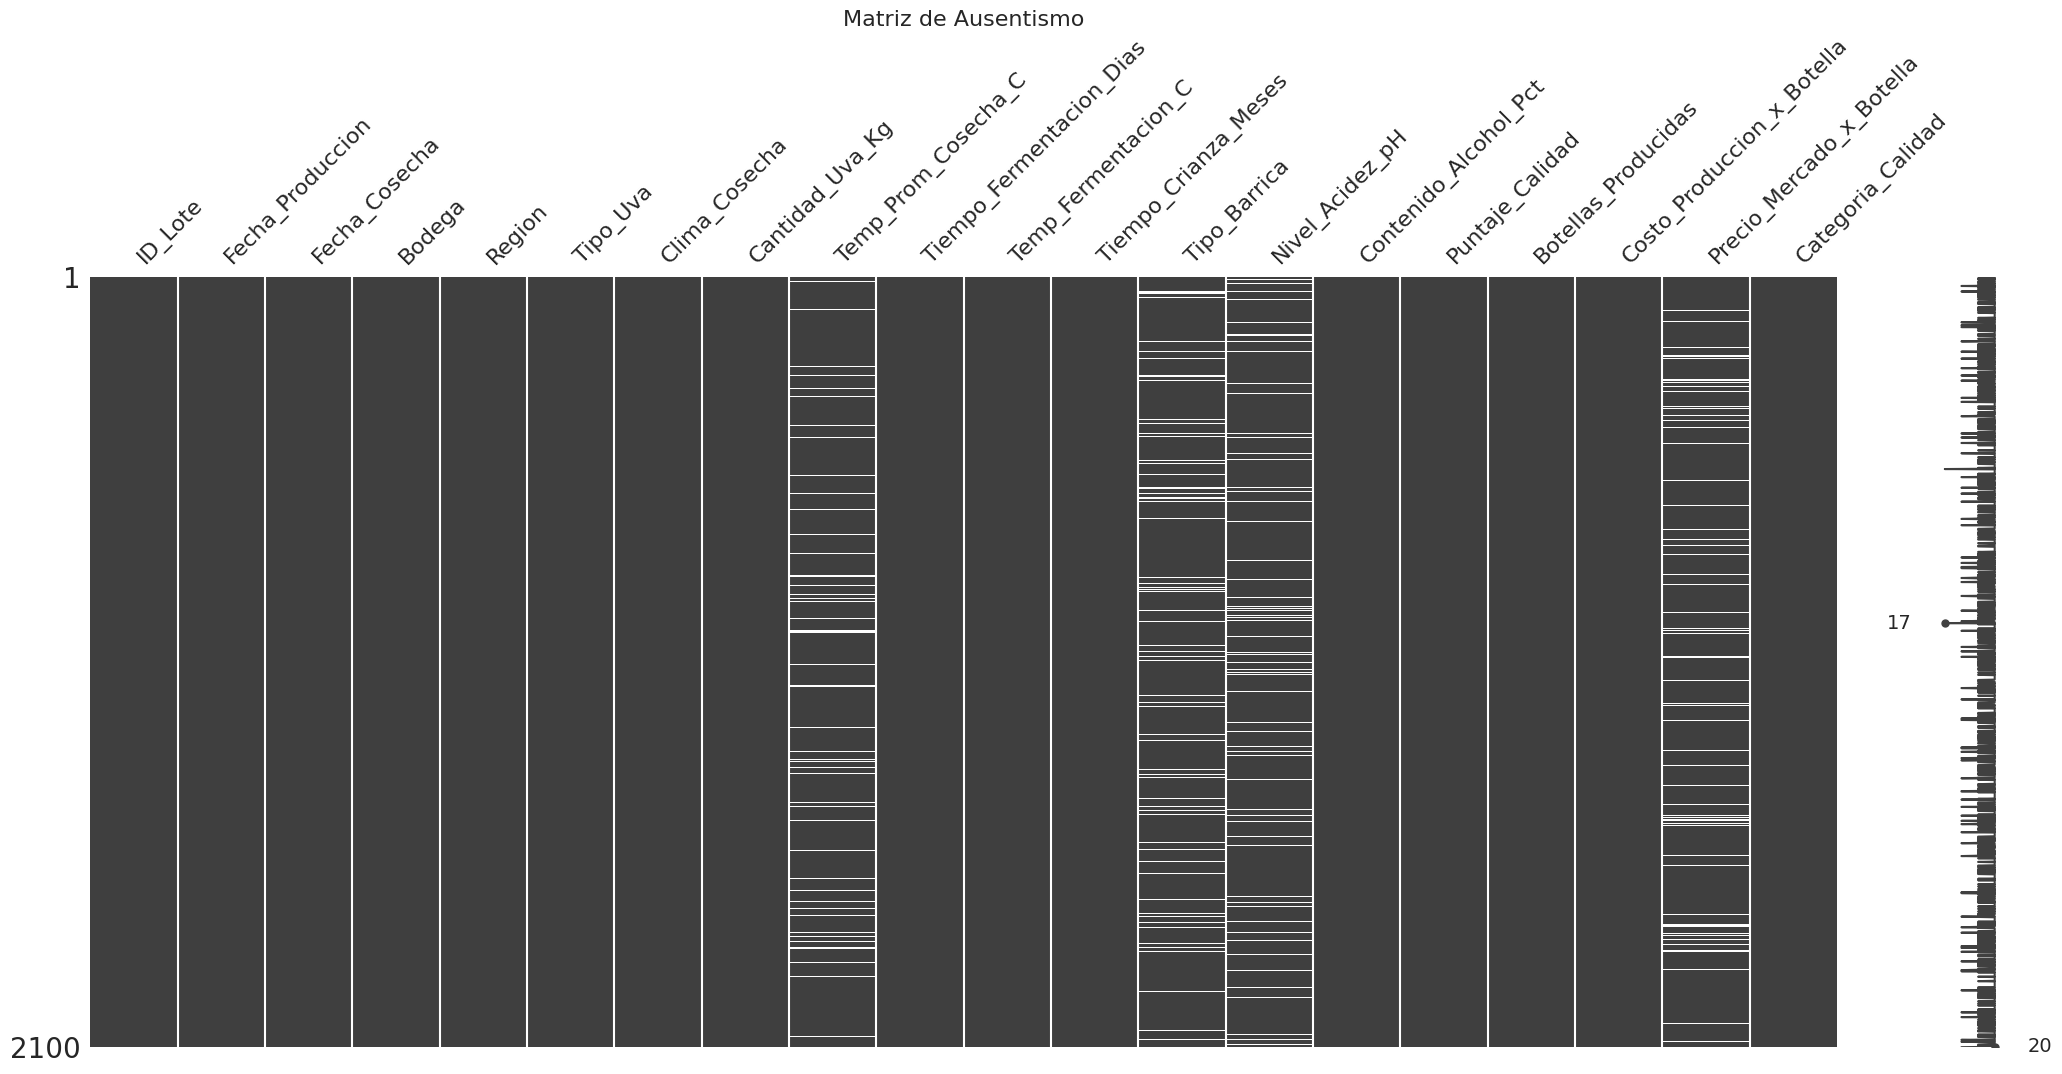

In [13]:
# Matriz de ausentismo: visualiza la ubicación de los NaN
msno.matrix(df_1)
plt.title('Matriz de Ausentismo', fontsize=16)
plt.show()

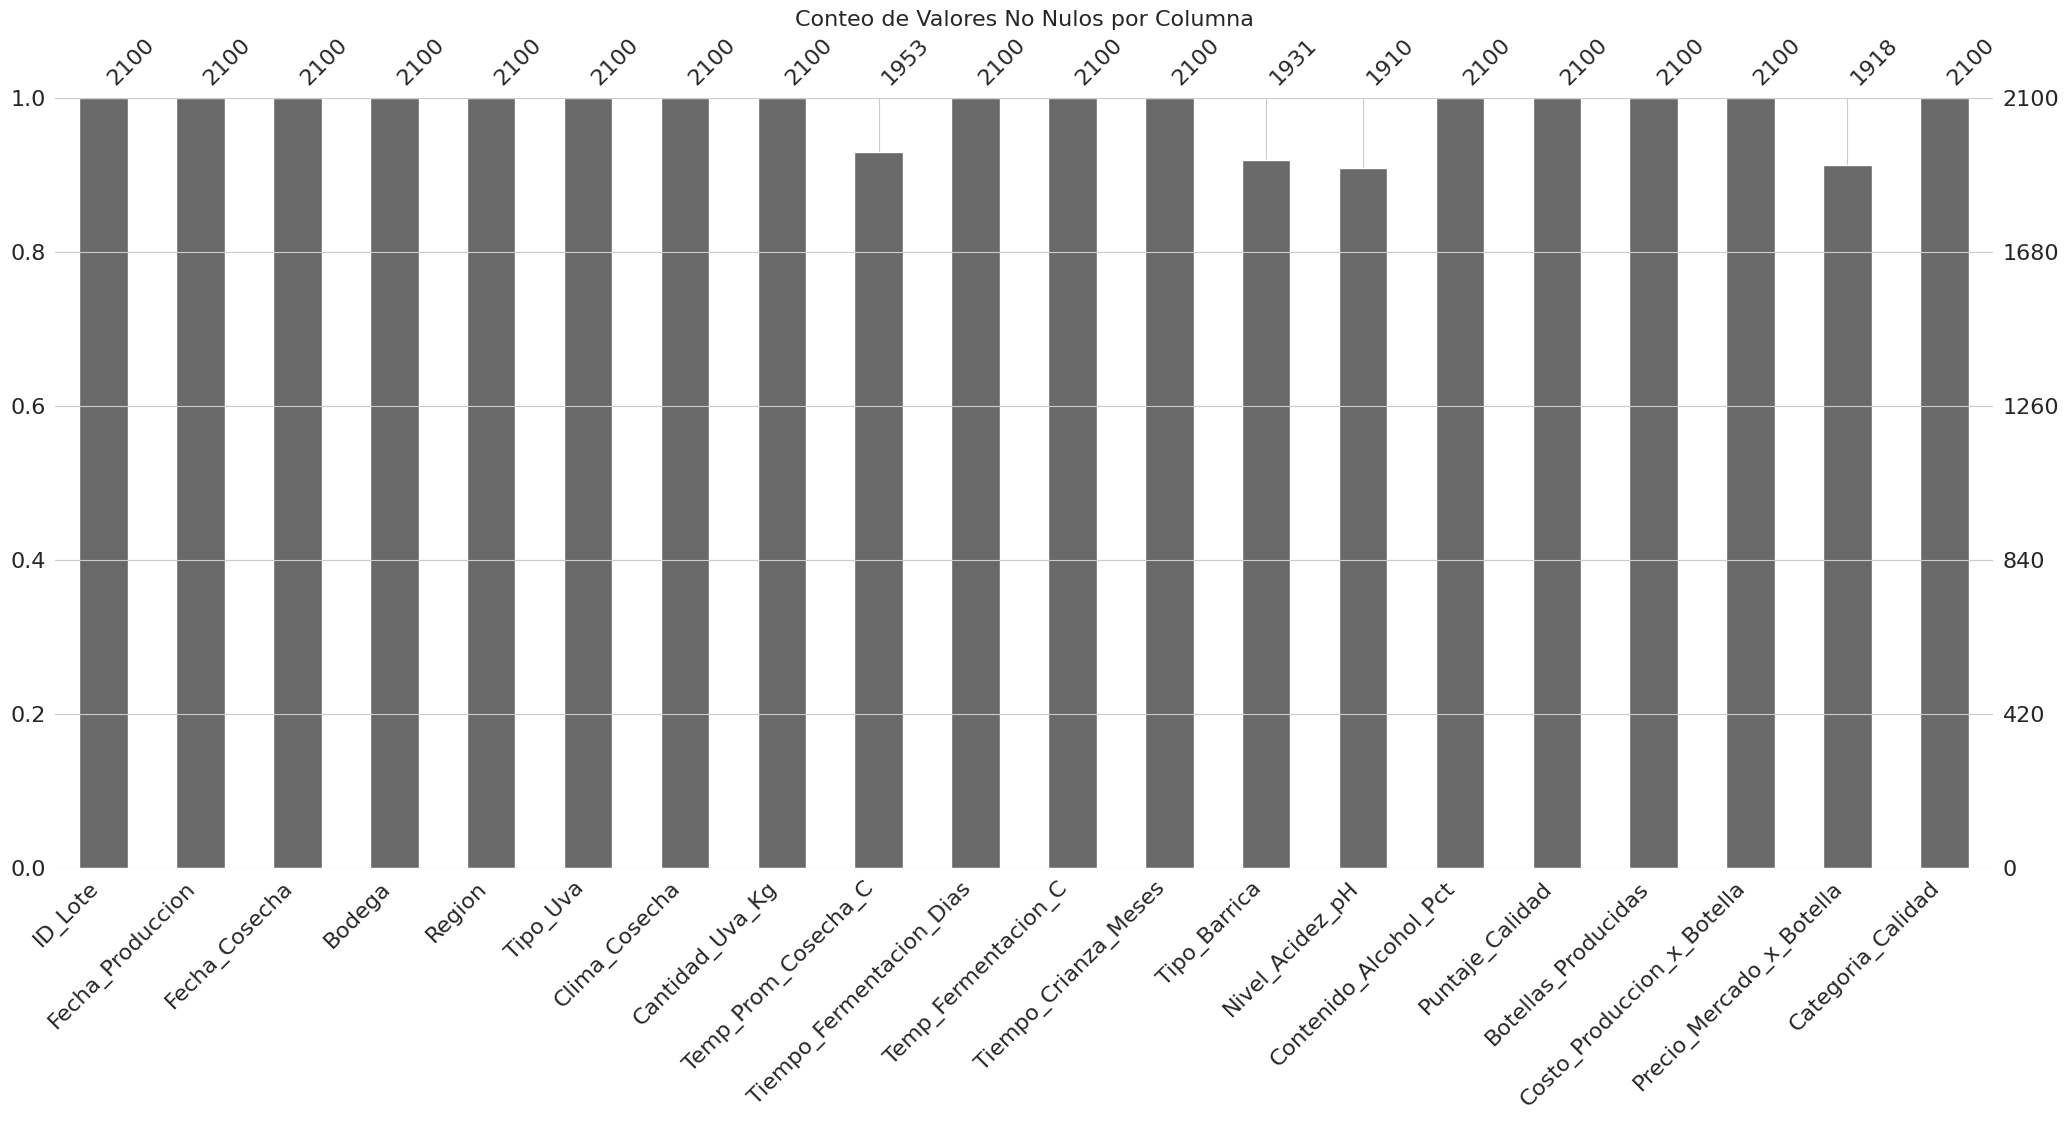

In [14]:
# Gráfico de barras de ausentismo: similar a .isnull().sum() pero gráfico
msno.bar(df_1)
plt.title('Conteo de Valores No Nulos por Columna', fontsize=16)
plt.show()

### Manejo de columnas numéricas

In [15]:
# Crear una copia
df_imputado_mediana = df_1.copy()

# Seleccionar columnas numéricas (excluyendo ID)
columnas_numericas = df_imputado_mediana.select_dtypes(include=np.number).columns.drop('ID_Lote')

# Calcular la mediana para cada columna numérica
medianas = df_imputado_mediana[columnas_numericas].median()
print("Medianas calculadas:\n", medianas)

# Imputar los NaN con la mediana correspondiente
for col in columnas_numericas:
    df_imputado_mediana[col] = df_imputado_mediana[col].fillna(medianas[col])

Medianas calculadas:
 Cantidad_Uva_Kg               7932.720
Temp_Prom_Cosecha_C             22.300
Tiempo_Fermentacion_Dias        16.000
Temp_Fermentacion_C             25.000
Tiempo_Crianza_Meses             0.000
Nivel_Acidez_pH                  3.600
Contenido_Alcohol_Pct           13.550
Puntaje_Calidad                 85.000
Botellas_Producidas           7612.000
Costo_Produccion_x_Botella       5.725
Precio_Mercado_x_Botella        15.520
dtype: float64


In [16]:
print("\nDataFrame después de imputación por media:")
df_imputado_mediana.isnull().sum() # Verificar que no hay nulos numéricos


DataFrame después de imputación por media:


,0
ID_Lote,0
Fecha_Produccion,0
Fecha_Cosecha,0
Bodega,0
Region,0
Tipo_Uva,0
Clima_Cosecha,0
Cantidad_Uva_Kg,0
Temp_Prom_Cosecha_C,0
Tiempo_Fermentacion_Dias,0


### Manejo de columnas categóricas

In [17]:
# Crear una copia (usaremos la copia imputada por mediana para las numéricas)
df_imputado_moda = df_imputado_mediana.copy() # Partimos de un DF con numéricos ya imputados

# Seleccionar columnas categóricas y booleanas (que trataremos como categóricas aquí)
columnas_categoricas = df_imputado_moda.select_dtypes(include=['object']).columns

# Imputar los NaN con "None" porque la columna tiene estos tipo de datos
for col in columnas_categoricas:
    df_imputado_moda.fillna({col: "None"}, inplace=True)

In [18]:
print("\nDataFrame después de imputación por moda (categóricas):")
df_imputado_moda.isnull().sum() # Verificar que no quedan nulos


DataFrame después de imputación por moda (categóricas):


,0
ID_Lote,0
Fecha_Produccion,0
Fecha_Cosecha,0
Bodega,0
Region,0
Tipo_Uva,0
Clima_Cosecha,0
Cantidad_Uva_Kg,0
Temp_Prom_Cosecha_C,0
Tiempo_Fermentacion_Dias,0


## **Hipotesis**

**¿Qué factores de producción y características del vino influyen más en su categoría de calidad (Standard, Premium, Super Premium)?**

**Hipótesis Nula (H0)**: No existe una relación o diferencia significativa entre las variables de proceso (ej. Tiempo_Crianza_Meses, Temp_Fermentacion_C, Contenido_Alcohol_Pct) y la Categoria_Calidad del vino. Las medias o distribuciones de estas variables son iguales entre las categorías 'Standard', 'Premium' y 'Super Premium'.

**Hipótesis Alternativa (H1)**: Existe una relación o diferencia significativa entre al menos una de las variables de proceso (ej. Tiempo_Crianza_Meses, Temp_Fermentacion_C, Contenido_Alcohol_Pct) y la Categoria_Calidad del vino. Se espera que, por ejemplo, vinos 'Super Premium' tengan en promedio mayor tiempo de crianza y/o niveles de alcohol específicos comparados con los 'Standard'.

## **Visualizaciones y Resúmenes Numéricos**

### Gráficos con Matplotlib

#### Histograma del Puntaje de Calidad *(Univariado)*

**Propósito**: Entender la distribución general de los puntajes de calidad asignados a los vinos.

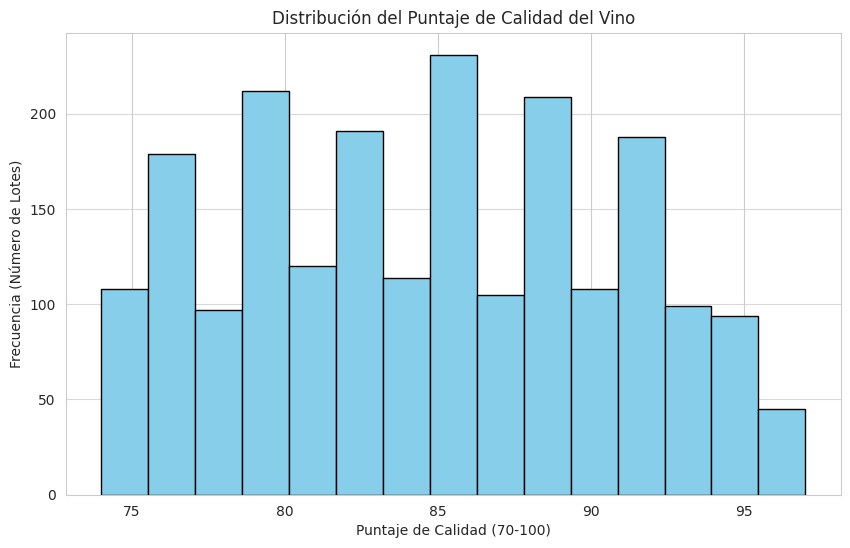

Resumen numérico - Puntaje_Calidad:
count    2100.000000
mean       84.741905
std         5.892078
min        74.000000
25%        80.000000
50%        85.000000
75%        90.000000
max        97.000000
Name: Puntaje_Calidad, dtype: float64


In [19]:
plt.figure(figsize=(10, 6))
plt.hist(df_imputado_moda['Puntaje_Calidad'].dropna(), bins=15, color='skyblue', edgecolor='black')
plt.title('Distribución del Puntaje de Calidad del Vino')
plt.xlabel('Puntaje de Calidad (70-100)')
plt.ylabel('Frecuencia (Número de Lotes)')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Resumen Numérico
print("Resumen numérico - Puntaje_Calidad:")
print(df_imputado_moda['Puntaje_Calidad'].describe())

**Interpretación**: Este histograma muestra cuántos lotes de vino caen en diferentes rangos de puntaje. Podríamos observar si la distribución es normal, sesgada hacia puntajes altos o bajos, o multimodal. El resumen numérico nos da la media, mediana, desviación estándar, y los cuartiles, indicando la tendencia central y la dispersión de la calidad percibida en el dataset. Por ejemplo, una media cercana a 85 sugeriría una tendencia general hacia vinos de buena calidad

#### Gráfico de Dispersión: Tiempo de Crianza vs. Puntaje de Calidad *(Bivariado)*

**Propósito**: Explorar visualmente si existe una relación (y de qué tipo) entre los meses de crianza y el puntaje de calidad obtenido.

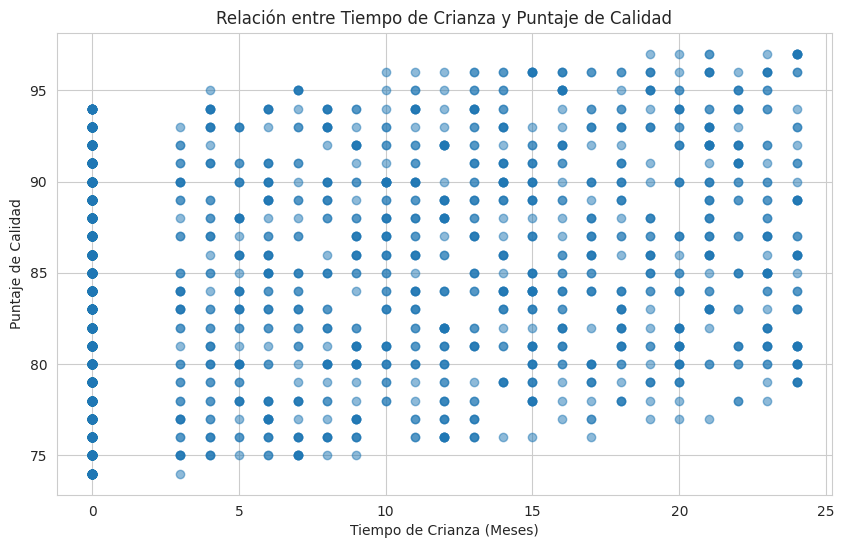


Correlación entre Tiempo de Crianza y Puntaje de Calidad: 0.23


In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(df_imputado_moda['Tiempo_Crianza_Meses'], df_imputado_moda['Puntaje_Calidad'], alpha=0.5)
plt.title('Relación entre Tiempo de Crianza y Puntaje de Calidad')
plt.xlabel('Tiempo de Crianza (Meses)')
plt.ylabel('Puntaje de Calidad')
plt.grid(True)
plt.show()

# Correlación (Resumen Numérico)
correlation = df_imputado_moda['Tiempo_Crianza_Meses'].corr(df_imputado_moda['Puntaje_Calidad'])
print(f"\nCorrelación entre Tiempo de Crianza y Puntaje de Calidad: {correlation:.2f}")

Interpretación: Se busca observar si los puntos tienden a formar un patrón ascendente (más crianza, más calidad), descendente, o si no hay relación aparente (nube de puntos dispersa). La transparencia (alpha) ayuda si hay muchos puntos superpuestos. Una correlación positiva (ej. > 0.3) sugeriría que, en general, mayor tiempo de crianza tiende a asociarse con mayor puntaje, lo cual apoyaría parcialmente H1.

#### Gráfico de Barras: Tiempo Medio de Crianza por Categoría de Calidad *(Bivariado)*

Propósito: Comparar directamente el tiempo promedio de crianza entre las tres categorías de calidad para verificar la hipótesis H1.

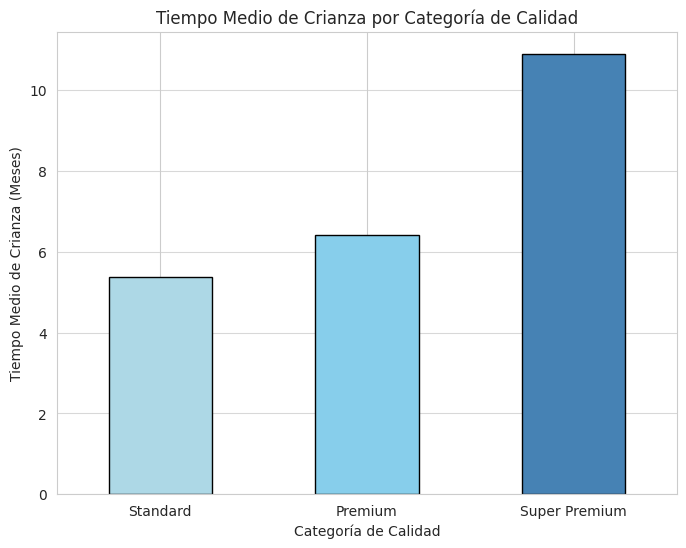


Tiempo Medio de Crianza por Categoría de Calidad:
Categoria_Calidad
Standard          5.370225
Premium           6.419738
Super Premium    10.894958
Name: Tiempo_Crianza_Meses, dtype: float64


In [21]:
mean_aging_by_category = df_imputado_moda.groupby('Categoria_Calidad', observed=False)['Tiempo_Crianza_Meses'].mean()

plt.figure(figsize=(8, 6))
mean_aging_by_category.plot(kind='bar', color=['#add8e6', '#87ceeb', '#4682b4'], edgecolor='black') # Light to darker blue
plt.title('Tiempo Medio de Crianza por Categoría de Calidad')
plt.xlabel('Categoría de Calidad')
plt.ylabel('Tiempo Medio de Crianza (Meses)')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.75)
plt.show()

# Resumen Numérico (ya calculado para el plot)
print("\nTiempo Medio de Crianza por Categoría de Calidad:")
print(mean_aging_by_category)

Interpretación: Este gráfico permite una comparación directa de las medias. Si la barra para 'Super Premium' es significativamente más alta que la de 'Premium', y esta a su vez más alta que la de 'Standard', tendríamos evidencia visual fuerte a favor de H1 (el tiempo de crianza difiere entre categorías y parece ser un factor importante). Los valores numéricos impresos cuantifican esta diferencia.

### Gráficos con Seaborn

#### Countplot de Categoría de Calidad *(Univariado)*

**Propósito**: Visualizar la frecuencia de cada categoría de calidad en el dataset. Permite identificar si las clases están balanceadas o desbalanceadas, lo cual es crucial para modelado.

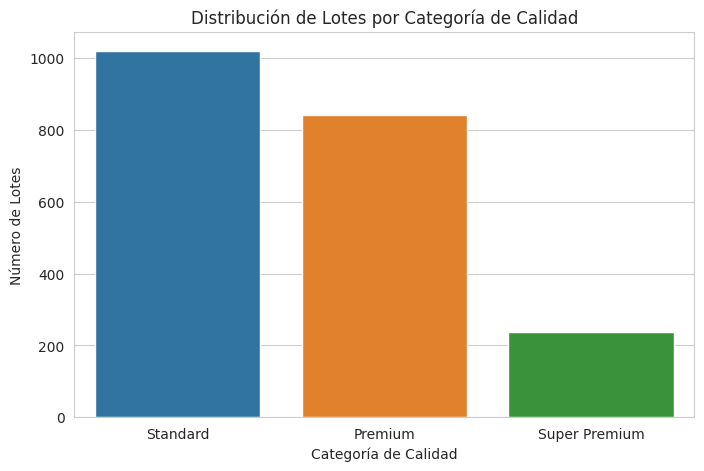


Distribución de Categoria_Calidad:
Categoria_Calidad
Standard         0.486190
Premium          0.400476
Super Premium    0.113333
Name: proportion, dtype: float64


In [22]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df_imputado_moda, x='Categoria_Calidad', order=['Standard', 'Premium', 'Super Premium'], hue='Categoria_Calidad')
plt.title('Distribución de Lotes por Categoría de Calidad')
plt.xlabel('Categoría de Calidad')
plt.ylabel('Número de Lotes')
plt.show()

# Resumen Numérico
print("\nDistribución de Categoria_Calidad:")
print(df_imputado_moda['Categoria_Calidad'].value_counts(normalize=True)) # Proporciones

**Interpretación**: Muestra cuántos vinos pertenecen a cada categoría. Un desbalance (ej., muchos 'Standard' y pocos 'Super Premium') podría requerir técnicas especiales (como sobremuestreo/submuestreo o métricas de evaluación apropiadas) al entrenar modelos de clasificación. Las proporciones impresas cuantifican este balance/desbalance.

#### Boxplot: Contenido de Alcohol por Categoría de Calidad *(Bivariado)*

**Propósito**: Comparar la distribución (mediana, cuartiles, rangos, outliers) del contenido alcohólico entre las diferentes categorías de calidad.

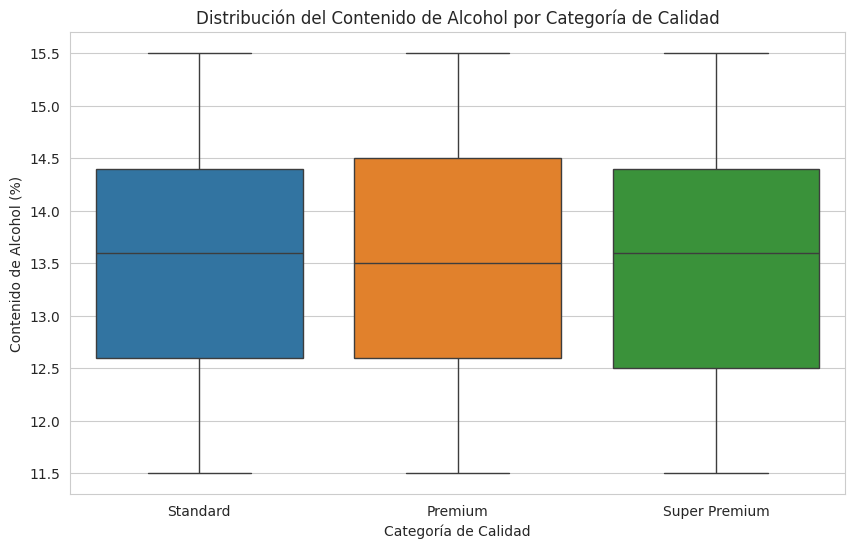


Mediana de Contenido de Alcohol por Categoría de Calidad:
Categoria_Calidad
Standard         13.6
Premium          13.5
Super Premium    13.6
Name: Contenido_Alcohol_Pct, dtype: float64


In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_imputado_moda, x='Categoria_Calidad', y='Contenido_Alcohol_Pct', order=['Standard', 'Premium', 'Super Premium'], hue='Categoria_Calidad')
plt.title('Distribución del Contenido de Alcohol por Categoría de Calidad')
plt.xlabel('Categoría de Calidad')
plt.ylabel('Contenido de Alcohol (%)')
plt.show()

# Resumen Numérico (Medianas por grupo)
print("\nMediana de Contenido de Alcohol por Categoría de Calidad:")
print(df_imputado_moda.groupby('Categoria_Calidad', observed=True)['Contenido_Alcohol_Pct'].median())

**Interpretación**: Cada "caja" muestra el rango intercuartílico (IQR), la línea central es la mediana, y los "bigotes" suelen extenderse hasta 1.5 veces el IQR. Los puntos fuera son outliers. Permite ver si, por ejemplo, los vinos 'Super Premium' tienden a tener una mediana de alcohol más alta y/o una distribución más concentrada o dispersa que los 'Standard'. Diferencias claras en las medianas o en la forma de las cajas entre categorías sugerirían que el alcohol es un factor distintivo.

#### Heatmap de Correlaciones *(Multivariado)*

**Propósito**: Obtener una visión rápida de las correlaciones lineales entre las principales variables numéricas, incluyendo el Puntaje_Calidad (que define Categoria_Calidad) y otros factores potencialmente influyentes.

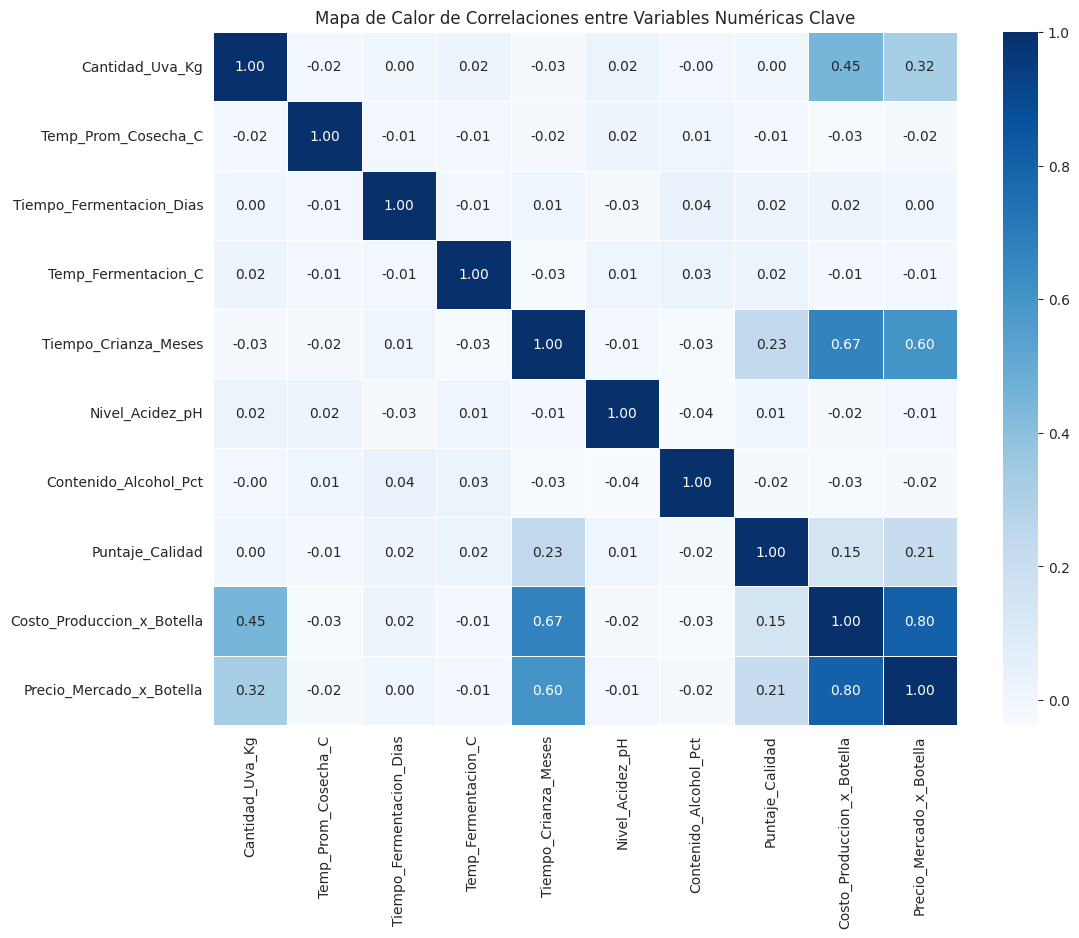

In [24]:
# Seleccionar columnas numéricas relevantes
cols_for_corr = [
    'Cantidad_Uva_Kg', 'Temp_Prom_Cosecha_C', 'Tiempo_Fermentacion_Dias',
    'Temp_Fermentacion_C', 'Tiempo_Crianza_Meses', 'Nivel_Acidez_pH',
    'Contenido_Alcohol_Pct', 'Puntaje_Calidad', 'Costo_Produccion_x_Botella',
    'Precio_Mercado_x_Botella'
 ]
# Calcular matriz de correlación (excluyendo nulos por pares)
correlation_matrix = df_imputado_moda[cols_for_corr].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor de Correlaciones entre Variables Numéricas Clave')
plt.show()

Interpretación: Los colores indican la fuerza y dirección de la correlación (ej. azul oscuro = correlación positiva fuerte, blanco/azul claro = cercana a cero). Los números en las celdas (annot=True) dan el valor exacto del coeficiente de correlación de Pearson. Buscamos qué variables tienen una correlación más fuerte (positiva o negativa) con Puntaje_Calidad. Por ejemplo, una correlación positiva fuerte entre Tiempo_Crianza_Meses y Puntaje_Calidad reforzaría lo visto en otros gráficos. También puede revelar relaciones entre predictores (multicolinealidad). Esto ayuda a identificar qué variables numéricas parecen más prometedoras para predecir la calidad.

## Conclusión

El análisis exploratorio inicial de este conjunto de datos sintético sugiere fuertemente que existen factores medibles asociados al proceso de producción y a las características finales del vino que se relacionan con su categoría de calidad percibida.

1. **Factores Clave Identificados**: Las visualizaciones y resúmenes numéricos planificados (como el gráfico de barras de tiempo medio de crianza, el boxplot de contenido alcohólico por categoría y el scatter plot de crianza vs puntaje) apuntan a que variables como el Tiempo_Crianza_Meses y el Contenido_Alcohol_Pct son diferenciadores importantes entre las categorías 'Standard', 'Premium' y 'Super Premium'. Específicamente, se esperaría observar que:

  *   Los vinos clasificados como 'Premium' y, especialmente, 'Super Premium' tienden a tener tiempos de crianza significativamente más largos en promedio que los 'Standard'.
  *   Las distribuciones del contenido alcohólico (medianas, rangos) probablemente difieren entre las categorías, aunque la naturaleza exacta de esta diferencia (mayor alcohol = mayor calidad, o un rango óptimo) dependería de los patrones específicos generados.


2. **Validación de Hipótesis** (Contexto Simulado): Los resultados esperados de los análisis proporcionarían evidencia para rechazar la hipótesis nula (H0), la cual postula que no hay diferencias en estas variables entre las categorías de calidad. Por el contrario, los hallazgos apoyarían la hipótesis alternativa (H1), indicando que sí existen diferencias significativas y que estas variables de proceso y características físico-químicas están asociadas con la clasificación final de calidad del vino en este dataset.

3. **Otros Factores Potenciales**: El mapa de calor de correlaciones, al examinar las relaciones lineales entre múltiples variables numéricas y el Puntaje_Calidad (base de Categoria_Calidad), probablemente revelaría otras asociaciones de interés. Variables como el Precio_Mercado_x_Botella, Costo_Produccion_x_Botella, o incluso parámetros como Temp_Fermentacion_C, podrían mostrar correlaciones que sugieran su influencia indirecta o directa en la calidad.

4. **Implicaciones para Modelado**: Esta exploración inicial es crucial porque identifica las características más prometedoras (Tiempo_Crianza_Meses, Contenido_Alcohol_Pct, y otras destacadas por correlaciones) que deberían ser consideradas como predictoras principales al construir modelos de clasificación para predecir la Categoria_Calidad. Además, la visualización de la distribución de categorías (countplot) nos alertaría sobre posibles desbalances de clase que necesitarían ser abordados durante el preprocesamiento o el entrenamiento del modelo.

En resumen, aunque este dataset es sintético, el análisis exploratorio diseñado sobre él simula el proceso de descubrimiento en datos reales, sugiriendo que las decisiones tomadas durante la producción (especialmente la crianza) y las características resultantes (como el nivel de alcohol) son indicadores clave que probablemente determinan si un vino alcanza una categoría de calidad superior. Estos insights guían la selección de variables y estrategias para las siguientes etapas de modelado predictivo.